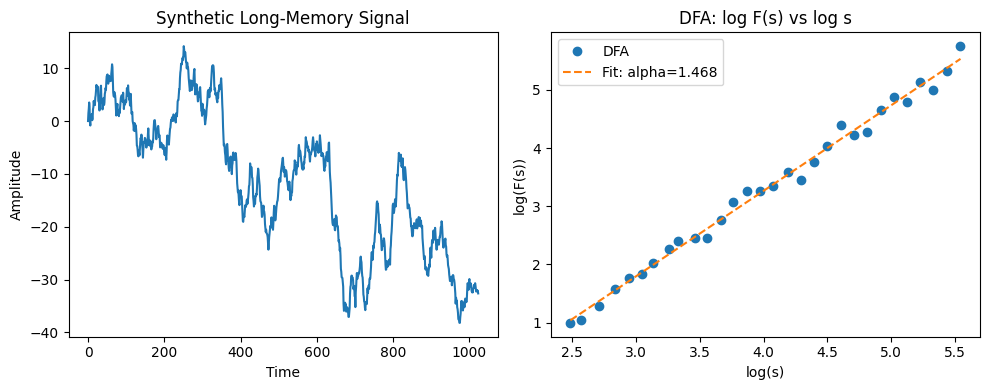

Estimated alpha: 1.468 (True H = 0.7)


In [2]:
# Detrended Fluctuation Analysis

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# ----------------------
# DFA DEMO
# ----------------------
def generate_fractional_gaussian_noise(N, H):
    """
    Approximate fractional Gaussian noise by filtering white noise.
    """
    white_noise = np.random.randn(N)
    fgn = np.zeros(N)

    for k in range(1, N):
        fgn[k] = fgn[k-1] + white_noise[k] + (H - 0.5) * (fgn[k-1] - fgn[k-2] if k > 1 else 0)

    return fgn


def detrended_fluctuation_analysis(signal, scales, order=1):
    N = len(signal)
    Y = np.cumsum(signal - np.mean(signal))
    F = []

    for s in scales:
        n_segments = N // s
        local_rms = []

        for i in range(n_segments):
            segment = Y[i*s:(i+1)*s]
            x = np.arange(s)
            coeffs = np.polyfit(x, segment, order)
            trend = np.polyval(coeffs, x)
            rms = np.sqrt(np.mean((segment - trend)**2))
            local_rms.append(rms)

        F.append(np.sqrt(np.mean(np.square(local_rms))))

    return np.array(F)

def plot_dfa(signal, H_true=0.7):
    N = len(signal)
    scales = np.unique(np.logspace(1.1, np.log10(N/4), num=30, dtype=int))
    F = detrended_fluctuation_analysis(signal, scales)

    # Linear regression on log-log
    log_scales = np.log(scales)
    log_F = np.log(F)
    alpha, intercept = np.polyfit(log_scales, log_F, 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(signal)
    plt.title("Synthetic Long-Memory Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    plt.subplot(1, 2, 2)
    plt.plot(log_scales, log_F, 'o', label="DFA")
    plt.plot(log_scales, alpha*log_scales + intercept, '--', label=f"Fit: alpha={alpha:.3f}")
    plt.title("DFA: log F(s) vs log s")
    plt.xlabel("log(s)")
    plt.ylabel("log(F(s))")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Estimated alpha: {alpha:.3f} (True H = {H_true})")

# Run DFA on synthetic data
N = 1024
H = 0.7
synthetic_signal = generate_fractional_gaussian_noise(N, H)
plot_dfa(synthetic_signal, H_true=H)

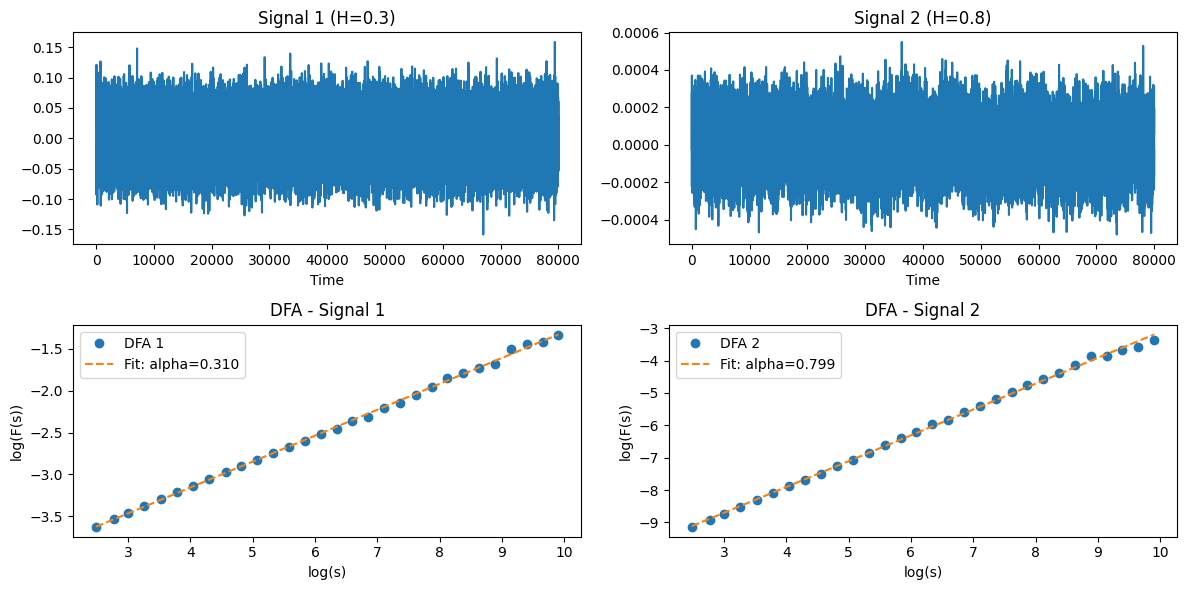

Estimated alpha for H=0.3: 0.310
Estimated alpha for H=0.8: 0.799


In [10]:
# DeepONet for 1D Heat Conduction with Mixed Function Types and Accurate DFA Demo

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from fbm import FBM  # pip install fbm

# ----------------------
# DFA DEMO using Accurate fBm Generator
# ----------------------
def generate_fbm_signal(N, H):
    """Generate fractional Brownian motion using the Davies-Harte method"""
    fbm_obj = FBM(n=N-1, hurst=H, length=1.0, method='daviesharte')
    return fbm_obj.fbm()

def detrended_fluctuation_analysis(signal, scales, order=1):
    N = len(signal)
    Y = np.cumsum(signal - np.mean(signal))
    F = []

    for s in scales:
        n_segments = N // s
        local_rms = []

        for i in range(n_segments):
            segment = Y[i*s:(i+1)*s]
            x = np.arange(s)
            coeffs = np.polyfit(x, segment, order)
            trend = np.polyval(coeffs, x)
            rms = np.sqrt(np.mean((segment - trend)**2))
            local_rms.append(rms)

        F.append(np.sqrt(np.mean(np.square(local_rms))))

    return np.array(F)

def plot_dfa_comparison(signal1, signal2, H1=0.3, H2=0.8):
    N = len(signal1)
    scales = np.unique(np.logspace(1.1, np.log10(N/4), num=30, dtype=int))

    F1 = detrended_fluctuation_analysis(signal1, scales)
    F2 = detrended_fluctuation_analysis(signal2, scales)

    log_scales = np.log(scales)
    log_F1 = np.log(F1)
    log_F2 = np.log(F2)

    alpha1, intercept1 = np.polyfit(log_scales, log_F1, 1)
    alpha2, intercept2 = np.polyfit(log_scales, log_F2, 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(signal1)
    plt.title(f"Signal 1 (H={H1})")
    plt.xlabel("Time")

    plt.subplot(2, 2, 2)
    plt.plot(signal2)
    plt.title(f"Signal 2 (H={H2})")
    plt.xlabel("Time")

    plt.subplot(2, 2, 3)
    plt.plot(log_scales, log_F1, 'o', label="DFA 1")
    plt.plot(log_scales, alpha1*log_scales + intercept1, '--', label=f"Fit: alpha={alpha1:.3f}")
    plt.title("DFA - Signal 1")
    plt.xlabel("log(s)")
    plt.ylabel("log(F(s))")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(log_scales, log_F2, 'o', label="DFA 2")
    plt.plot(log_scales, alpha2*log_scales + intercept2, '--', label=f"Fit: alpha={alpha2:.3f}")
    plt.title("DFA - Signal 2")
    plt.xlabel("log(s)")
    plt.ylabel("log(F(s))")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Estimated alpha for H={H1}: {alpha1:.3f}")
    print(f"Estimated alpha for H={H2}: {alpha2:.3f}")

# Run DFA comparison with accurate fBm
N = 80000
H1 = 0.3
H2 = 0.8
signal1 = generate_fbm_signal(N, H1)
signal2 = generate_fbm_signal(N, H2)
fGn_signal1 = np.diff(signal1)
fGn_signal2 = np.diff(signal2)

plot_dfa_comparison(fGn_signal1, fGn_signal2, H1, H2)
